In [17]:
using VMLS
using LinearAlgebra
using Plots
using Random
using MAT

## Part A: More k-means by comparing angles between vectors (6  exercises).
In **Part D2** of **Project 1** you were asked to modyfy the **k-means clustering algorithm** to do the clustering by comparing angles between vectors instead of distances. Here we will look into this matter in a little more detail.

#### Read carefully to understand the following function for calculating the [Cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity#Definition)s between a vector ($v$), and all the rows of a matrix ($X$):
(We assume that $v$ has the same dimension as the rows in $X$)

In [163]:
function allCosDist(X,v) # Calculate all (squared) cosine distances between the X-rows and the vector v.
# Inputs: X - data matrix containing N samples of p-dimensional features.
#         v - p-dimensional row vector
# Output: d - a vector of (squared) cosine distances between the various rows of X to v.
    N = size(X,1); d = zeros(N);
    nv = norm(v); # The norm of v
    for i = 1:N
        x = X[i,:]
        cosvx = x'v/(norm(x)*nv) # Cosine of the angle between x and v
        d[i] = 1-cosvx^2;        # The squared cosine distance
    end
    return d
end

allCosDist (generic function with 1 method)

Here is **a more compact version** of this function using matrix multiplication instead of the above **for-loop**:

In [164]:
function allCosDist_(X,v) # Calculate all distances between the X-rows and vector v.
# Inputs: X - data matrix containing N samples of p-dimensional features.
#         v - p-dimensional row vector
# Output: a vector of (squared) cosine distances between the various rows of X to v.
# -------------------------------------------------------------------------------------    
Xv    = X*v                      # a vector containing all inner products between the X-rows and v
nX    = sqrt.(sum(X.^2,dims = 2)) # a vector containing the norms of all the X-rows
nvnX  = norm(v)*nX;               # The norm of v multiplied with each of the norms in nX
cosvX = Xv./nvnX                  # Cosine-values for all angles (between v and each X-row)
return 1 .-cosvX.^2               # The associated squared cosine-distances between v and each of the X-rows
end

allCosDist_ (generic function with 1 method)

### Ex. A1: 
Inspect the above code and suggest another version of this function **in one single line of code:**

In [165]:
allCosDist_(X, v) = 1 .- (X*v ./ (norm(v) * sqrt.(sum(X.^2, dims = 2)))).^2

allCosDist_ (generic function with 1 method)

### Ex. A2:
Lets **generate som random data** for comparing speed and results of the two algorithms:

In [166]:
n = 500000; # number of samples in X
p = 200;    # number of features in X
X = randn(n,p); # Matrix of n rows and p columns with entries randomly drawn from the standard normal distribution.
v = randn(p);   # The vector 

**Write code that calculates the squared cosine distances** between `v` and the `X`-rows by the two function alternatives `allCosDist` and `allCosDist_`. Your code should compare the (two) resulting vectors of squared cosine distances and display the corresponding execution times.

In [167]:
# < fill in the appropriate code ... >
@time d1 = allCosDist(X,v)
@time d2 = allCosDist_(X,v)
norm(d1-d2)

  0.346392 seconds (507.57 k allocations: 866.478 MiB, 3.90% compilation time)
  0.360484 seconds (103.75 k allocations: 788.994 MiB, 21.72% gc time, 14.19% compilation time)


1.6093256225679544e-14

### Ex. A3 - introduction:
Here is an implementation of the **k-means clusting** comparing squared cosine distances (angles) between vectors instead of distances:

In [168]:
function anewkmeans(X, k; tol = 5e-3, maxiter = 100)
# ------- Another version of the k-means algorithm comparing samples to cluster centers by cosine distances --------
# INPUT: -----------------------------------------------------------------------------------------------------------
# X        - data matrix (observed datapoints are rows in X).
# k        - the number of clusters (an integer >= 2, typically 2 to something smaller than the number of rows in X).
# OUTPUT: -----------------------------------------------------------------------------------------------------------
# C        - vector of final cluster labels (1,..,k) assigned to each datapoint.
# Z        - matrix of final cluster centers (given as rows)
# JS       - objective function values describing the improvements of the clustering process (smaller means better clustering)
# cs       - the sizes of each cluster
# ------------------------------------------------------------------------------------------------------------------
JS = [];                             # objective function values describing the mean squared distances of the clustering process.
N      = size(X,1);                  # number of samples (rows) in tha data matrix
D2     = Array{Float64}(undef, N, k);# Matrix for storing distances between samples and cluster centers. #D2 = zeros(N, k); #D2 = nan(N,k);
C      = zeros(N);                   # N-vector of the cluster assignments
cs     = zeros(k);                   # k-vector to contain the cluster sizes

Jcurrent = 0; Jprevious = -1; # Jcurrent and Jprevious denotes objective function values - for updates in the clustering process.
ids = randperm(N)[1:k];       # k random integers in [1, N] for random selection of X-samples as initial cluster centers.
Z   = copy(X[ids,:]);         # The initial randomy selected cluster centers according to "ids" above.
iter = 1;                     # For counting the number of iterations before convergence

while abs((Jcurrent-Jprevious)/Jprevious) > tol  && iter <=maxiter  # Repeat until convergence of the objective function values
    for i = 1:k # Here we calculate the squared cosine distances for all samples to the cluster centers.
       D2[:,i] = allCosDist_(X,Z[i,:]); 
    end
    
    # Identify shortest distance and corresponding cluster label for each sample:
    minD2, C = findmin(D2, dims=2); C = getindex.(C,2); # convert from CartesianIndex to column number  
    
    # Update previous and current objective function values
    Jprevious = Jcurrent; Jcurrent = sum(minD2)/N; JS = [JS; Jcurrent];                    

    # Update the cluster centers based on the labelling in C:
    for i = 1:k
        rows_i = findall(vec(C.==i));                   # Find row-numbers of all cluster members of the i-th cluster.
        cs[i] = length(rows_i)                          # Number of samples in cluster i.
        if cs[i]>0                                      # Update if i-th cluster is non-empty.
        Z[i,:] = sum(X[rows_i,:],dims = 1)./cs[i]       # Update cluster centers as the mean of the cluster members.
        end
    end #, println("Iteration ", iter, ": Jclust = ", Jcurrent, ".");  
    iter +=1
end 

return C, Z, JS, cs;
end

anewkmeans (generic function with 1 method)

### We can generate a 2D "angular" dataset by using [rotation matrices](https://en.wikipedia.org/wiki/Rotation_matrix) as follows ...

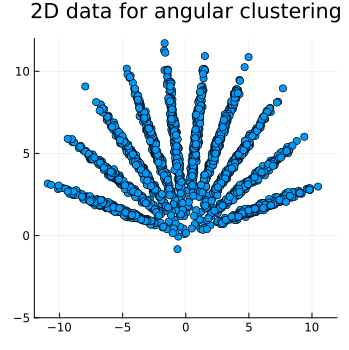

In [169]:
K = 10; # The true number of clusters in generation of angular dataset.
RM(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]; # Counterclockwise rotation matrix function (by the agle θ).

np = 250;         # Number of samples in each cluster
XA = zeros(2,0);
scale = 2;
for k = 1:K
    θk = (k/(K+1))*pi; # The counterclockwise rotation angle
    #XA = [XA RM(θk)*[ scale*rand(np)'.+0.3;  0.1*randn(np)']];
    XA = [XA RM(θk)*[ scale*randn(np)'.+6;  0.1*randn(np)']]; # Bulid a matrix of rotated 2D vectors.
end
XA = XA'; # Finally, we want the 2D-vectors as rows.
    
# Scatter plot of XA-data
N = length(X)
scatter(title = "2D data for angular clustering",
    label = " ", size = (350,350), xlims = (-5*scale-2,5*scale+2), ylims = (-5,5*scale+2), legend=false)
scatter!(XA[:,1], XA[:,2])


### ... and then test our angular clustering algorithm
If you run the following code for clustering algorithm for the angular dataset many times (even by using the correct number of clusters), you will observe that the algorithm converges to different solutions depending on the random initializations of the cluster centers (`Z`) in the clustering algorithm:

Any[0.07144198698533494, 0.05349016872493728, 0.027061433764920918, 0.02147291299438752, 0.019429429472465457, 0.014277385613250704, 0.012663746404631257, 0.012663352761146222]

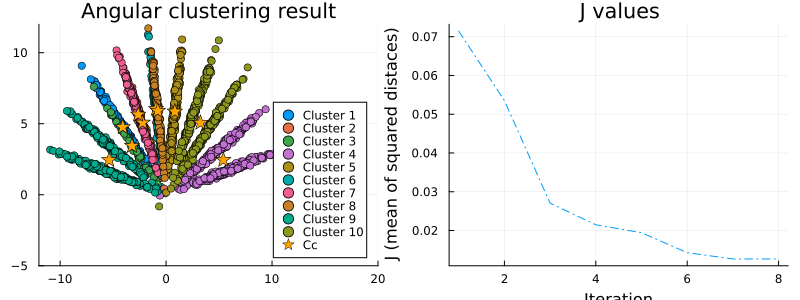

In [170]:
k = 10; # Cluster size (also try alternative values for k)
Cid, Cc, J, cs = anewkmeans(XA, k);

pS = scatter(title = "Angular clustering result",
    label = " ", legend = :bottomright, size = (350,300), xlims = (-5*scale-2,5*scale+10), ylims = (-5,5*scale+2))
    for i=1:k
        snr = findall(vec(Cid.==i)); # the sample numbers of the i-th cluster
        scatter!(pS, XA[snr,1], XA[snr,2], label = string("Cluster ",i))
    end
# Add cluster centers to the scatter plot:
scatter!(pS, Cc[:,1],Cc[:,2], marker = :star, markersize = 8, color = :orange, label = "Cc", legend=:bottomright)

# Plot objective function values from clustering process
pJ = plot(J, linestyle = :dashdot, title = "J values", ylabel = "J (mean of squared distaces)", 
    xlabel="Iteration", grid = true, size = (400,300), legend = false)
print(J)
plot(pS, pJ, layout = (1,2), size=(800,300))

### Ex. A3 - to do:
Make a new function `anewkmeansR(X,k,R)` that repeats running `anewkmeans(X,k)` `R` times and returns `CidR, CcR, JR, csR` corresponding to the best clustering model among the `R` solutions:

(NOTE: This is the improvement we were looking for in **Ex. D4 of Project 1**.)

In [171]:
function anewkmeansR(X, k, R)
"""iterative K-means clustering"""

    #init vars
    best_J = Inf
    best_C = nothing
    best_Z = nothing
    best_cs = nothing
    best_JS = nothing

    # Run the anewkmean R times
    for r = 1:R
        C, Z, JS, cs = anewkmeans(X, k)

        # check best 
        if JS[end] < best_J # comparing the obj func
            best_J = JS[end]
            best_C = C
            best_Z = Z
            best_cs = cs
            best_JS = JS
        end
    end

    # Return result
    return best_C, best_Z, best_JS, best_cs
end

anewkmeansR (generic function with 1 method)

### Ex. A4:
**Test** the `anewkmeansR(X,k,R)` algorithm by using `R=25;` to **produce graphics** similar to the testing of `anewkmean(X, k)` above:

Any[0.02904599013999043, 0.01126121998278918, 0.00818914130377909, 0.004475404090113542, 0.004391921133622238, 0.004390409430340473]

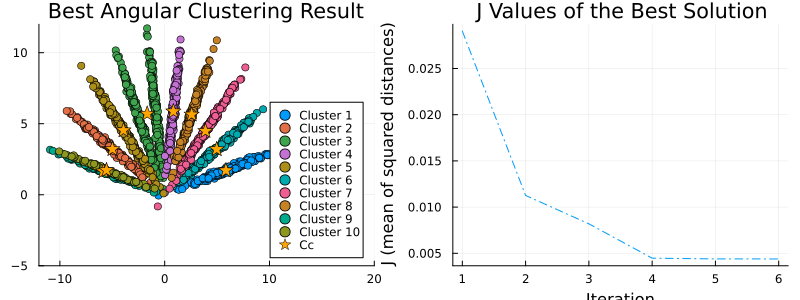

In [172]:
### based on the code above

k = 10
R = 25
CidR, CcR, JR, csR = anewkmeansR(XA, k, R)

pS = scatter(title = "Best Angular Clustering Result",
             label = " ", legend = :bottomright, size = (300, 200), xlims = (-5*scale-2,5*scale+10), ylims = (-5,5*scale+2))
scale = 1
for i = 1:k
    snr = findall(vec(CidR .== i)) 
    scatter!(pS, XA[snr, 1], XA[snr, 2], label = string("Cluster ", i))
end

# Add cluster centers to the scatter plot
scatter!(pS, CcR[:, 1], CcR[:, 2], marker = :star, markersize = 8, color = :orange, label = "Cc", legend = :bottomright)


# Plot objective function values from the clustering process
pJ = plot(JR, linestyle = :dashdot, title = "J Values of the Best Solution",
          ylabel = "J (mean of squared distances)", xlabel = "Iteration",
          grid = true, size = (600, 500), legend = false)


print(JR)
plot(pS, pJ, layout = (1, 2), size = (800, 300))

### Ex. A5 - an idea for finding a good choice of $k$ (the number of clusters):
In the above testing we have "cheated" in the sense that we run the clustering algorithms with $k$ egual to the number of clusters used to generate our random dataset.

It would be more realistic if we designed an algorithm that also tries to "guess" the correct number `k` of clusters from the range of integers `1` to `K`.

Write a program that implements this idea, and run it with a maximum of `K = 20`clusters. **For a fair comparison** of the goodness of solutions for different values of `k`, you should consider `(k^2)*J[end]` when you consider which value of `k` to choose "the best" clustering solution":

In [173]:
#K = 20;
#R = 25;

function find_k(X, max_k, R)
    #iterative anewkmeansR

    best_k = 1
    min_score = Inf
    Jmin = Inf
    scores = []
    

    for k = 1:max_k
        best_C, best_Z, best_JS, best_cs = anewkmeansR(X, k, R)
        J_end = best_JS[end]

        
        score = (k^2) * J_end # penalize for more clusters (balance)
        push!(scores, score) 
        println("k = ", k, " J = ", J_end, " score = ", score)

        #Store if better (smaller)
        if score < min_score
            min_score = score
            Jmin = J_end
            best_k = k
        end
    end
    return best_k, Jmin, min_score
end

find_k (generic function with 1 method)

In [174]:
# kmin, Jmin
kmin, Jmin, scores = find_k(XA, 20, 25)


k = 1 J = 0.4500410063875173 score = 0.4500410063875173
k = 2 J = 0.14924452806286537 score = 0.5969781122514615
k = 3 J = 0.07041847760281368 score = 0.6337662984253232
k = 4 J = 0.04009411703254584 score = 0.6415058725207334
k = 5 J = 0.020974265809140986 score = 0.5243566452285247
k = 6 J = 0.016451146089890692 score = 0.5922412592360649
k = 7 J = 0.012481773308700888 score = 0.6116068921263434
k = 8 J = 0.00836066059808986 score = 0.535082278277751
k = 9 J = 0.004427769414984741 score = 0.35864932261376403
k = 10 J = 0.0043940936829513855 score = 0.43940936829513855
k = 11 J = 0.00046114897120422163 score = 0.055799025515710816
k = 12 J = 0.0004295816118147135 score = 0.06185975210131874
k = 13 J = 0.0004068976410129444 score = 0.0687657013311876
k = 14 J = 0.00038870273097467575 score = 0.07618573527103645
k = 15 J = 0.00036101206576471975 score = 0.08122771479706195
k = 16 J = 0.0003430148443358343 score = 0.08781180014997358
k = 17 J = 0.00031566884244564207 score = 0.0912282954

(11, 0.00046114897120422163, 0.055799025515710816)

### Ex. A6 (optional):
Solve **Ex. D3 in Project 1** by using your program from **Ex. A5** to identify the clustering solution for "the best" number of clusters. Finally you should display the most frequent words in each cluster and the titles (documents) most similar to the cluster centers):

 **Ex. D3:** Apply the **"anewkmeans"-algorithm** to the wikipedia data as described in [section 4.4.2 of the VMLS Julia companion](https://web.stanford.edu/~boyd/vmls/vmls-julia-companion.pdf#page=46) (display most frequent words in each cluster and the titles (documents) most similar to the cluster centers):

In [175]:
# < write your program here ...>
articles, dictionary, titles = wikipedia_data();
art = hcat(articles...)';
N = size(art,1)


k_min, J_min = find_k(art, 15, 20)
println("The optimal number of clusters is: ", k_min)
println("The minimum score is: ", J_min)


k = 1 J = 0.8788907273995187 score = 0.8788907273995187
k = 2 J = 0.8348533159599653 score = 3.339413263839861
k = 3 J = 0.8087297293142186 score = 7.278567563827967
k = 4 J = 0.7823221195560058 score = 12.517153912896093
k = 5 J = 0.7628322345358111 score = 19.070805863395275
k = 6 J = 0.7531209861076625 score = 27.11235549987585
k = 7 J = 0.7417768328554135 score = 36.34706480991526
k = 8 J = 0.7324577733032974 score = 46.877297491411035
k = 9 J = 0.7189978042542532 score = 58.23882214459451
k = 10 J = 0.7163256795321477 score = 71.63256795321476
k = 11 J = 0.7125917589582885 score = 86.22360283395291
k = 12 J = 0.7128565846637909 score = 102.65134819158588
k = 13 J = 0.7068452994662306 score = 119.45685560979298
k = 14 J = 0.696302043774226 score = 136.4752005797483
k = 15 J = 0.6940176666778007 score = 156.15397500250518
The optimal number of clusters is: 1
The minimum score is: 0.8788907273995187




> Annoying! It choses 1 cluster, I'm pretty sure its because of the cost term k^2, which gives an unfair advantage to k = 1$

> I tried changing it to: $S(J(k)) = J(k) +  \frac{k^2}{4} * J(k)$, but it still choses k = 1

from (https://stats.stackexchange.com/questions/51556/choosing-clusters-for-k-means-the-1-cluster-case)

In [18]:
using Statistics

In [177]:
function find_k_mod(X, max_k, B, R)
""" Function to compare the results of anewkmeansR with the results of B random datasets // testing the null hypothesis"""
    R = R
    n, p = size(X)
    gaps = zeros(max_k)
    sdk = zeros(max_k)
    scores = []


    noise_df = [randn(n, p) for _ in 1:B]
    
    for k = 1:max_k
        best_C, best_Z, best_JS, best_cs = anewkmeansR(X, k, R)
        total_cost = best_JS[end]
        
        total_cost_ref = zeros(B)
        for b = 1:B
            _, _, JS, _ = anewkmeansR(noise_df[b], k, R)
            total_cost_ref[b] = JS[end] * (k^2)
        end


        #we need a penalty term
        penalty = log(k) - p/2

        gaps[k] = mean(log.(total_cost_ref)) - log(total_cost) - penalty
        sdk[k] = std(log.(total_cost_ref)) * sqrt(1 + 1/B)
        push!(scores, total_cost)
        println("k = ", k, " gap = ", gaps[k], " sdk = ", sdk[k])
    end

    optimal_k = findmax(gaps)[2]
    return optimal_k, gaps, sdk, scores

end


find_k_mod (generic function with 1 method)

In [178]:
max_k = 20
B = 10 
R = 3

optimal_k, gaps, sdk, scores = find_k_mod(art, max_k, B, R)
println("Optimal number of clusters: ", optimal_k)


k = 1 gap = 2211.6268787105487 sdk = 3.3468679434881965e-5
k = 2 gap = 2212.3646369218873 sdk = 4.7367108322444915e-5
k = 3 gap = 2212.7980922397724 sdk = 5.183399757362034e-5
k = 4 gap = 2213.1209198063416 sdk = 4.4612767903276996e-5
k = 5 gap = 2213.3535021893704 sdk = 8.66266863733144e-5
k = 6 gap = 2213.563690524512 sdk = 6.353240118819371e-5
k = 7 gap = 2213.7221731264885 sdk = 6.13083578109916e-5
k = 8 gap = 2213.857996569632 sdk = 7.890710529245395e-5
k = 9 gap = 2213.988046411567 sdk = 0.00010213348532711085
k = 10 gap = 2214.0971346853576 sdk = 0.00010329864395982948
k = 11 gap = 2214.2141714206514 sdk = 0.00013732929231100434
k = 12 gap = 2214.301283587707 sdk = 0.00012724142717737724
k = 13 gap = 2214.3692235833446 sdk = 0.00010158469683870516
k = 14 gap = 2214.4494883614 sdk = 9.157054223125208e-5
k = 15 gap = 2214.5209948736315 sdk = 0.00012674615399789862
k = 16 gap = 2214.5847409786466 sdk = 0.00013298572943459225
k = 17 gap = 2214.673772212 sdk = 0.0002067024619227414
k

In [179]:
#check gaps[k] > gaps[k+1] - sdk[k+1]
for k = 1:max_k - 1
    diff = gaps[k] - gaps[k+1] + sdk[k+1]
    println("k = ", k, " diff = ", diff)
end


k = 1 diff = -0.7377108442302646
k = 2 diff = -0.4334034838875174
k = 3 diff = -0.32278295380132754
k = 4 diff = -0.2324957563424112
k = 5 diff = -0.21012480274034992
k = 6 diff = -0.15842129361881868
k = 7 diff = -0.13574453603834336
k = 8 diff = -0.1299477084497062
k = 9 diff = -0.10898497514638864
k = 10 diff = -0.11689940600151186
k = 11 diff = -0.08698492562851576
k = 12 diff = -0.0678384109406777
k = 13 diff = -0.08017320751337592
k = 14 diff = -0.0713797660772829
k = 15 diff = -0.0636131192856359
k = 16 diff = -0.08882453089165758
k = 17 diff = -0.05736387641733471
k = 18 diff = -0.047406425364596556
k = 19 diff = -0.06867019056718444


> Let's take a estimated guess that 15 clusters is a good choice based on the result from find_k and our version find_k_mod

In [180]:
# OUTPUT: -----------------------------------------------------------------------------------------------------------
# C        - vector of final cluster labels (1,..,k) assigned to each datapoint.
# Z        - matrix of final cluster centers (given as rows)
# JS       - objective function values describing the improvements of the clustering process (smaller means better clustering)
# cs       - the sizes of each cluster

# best_C / (500, 1) - cluster assigment for 500 articles

# best_Z / (15, 4423) - 15 centroid centers, each row is a cluster center in 4423 dimensions (words)

# best JS / (5, 1) - improvement

# best_CS /  - amount of articles in each cluster

In [181]:
#print size of art 

println(size(art))

(500, 4423)


In [182]:
C, Z, JS, cs = anewkmeansR(art, 15, 20);


N = size(articles, 1)
k = 15
reps = Z;
assignment = C;

In [183]:
#print size of articles and reps(assigment)

println(size(articles))

println(size(reps))

println(size(assignment))


(500,)
(15, 4423)
(500, 1)


In [184]:
d = [norm(articles[i] - reps[assignment[i][1], :]) for i = 1:N]; #Distance between article and assigned cluster center for that article

In [185]:

for j = 1:k
    group = [i for i = 1:N if assignment[i] == j]
    println("\nCluster ", j, " (", length(group), " articles)")

    # Identifying top words in the cluster center
    I = sortperm(reps[j, :], rev=true)
    top_words = dictionary[I[1:5]]
    println("Top words: \n ", top_words)

    # Finding documents closest to the cluster center
    println("Documents closest to representative: ")
    group_distances = [d[i] for i in group]
    closest_indices = sortperm(group_distances)
    for i = 1:min(5, length(closest_indices))
        println(" ", titles[group[closest_indices[i]]])
    end
end



Cluster 1 (16 articles)
Top words: 
 ["match", "win", "championship", "event", "style"]
Documents closest to representative: 
 Wrestlemania_32
 Payback_(2016)
 Survivor_Series_(2015)
 Night_of_Champions_(2015)
 Royal_Rumble_(2016)

Cluster 2 (60 articles)
Top words: 
 ["film", "star", "role", "play", "appear"]
Documents closest to representative: 
 Ben_Affleck
 Johnny_Depp
 Maureen_O'Hara
 Kate_Beckinsale
 Leonardo_DiCaprio

Cluster 3 (31 articles)
Top words: 
 ["reagan", "president", "trump", "presidential", "united"]
Documents closest to representative: 
 Marco_Rubio
 Carly_Fiorina
 Jim_Webb
 Hillary_Clinton
 Antonin_Scalia

Cluster 4 (11 articles)
Top words: 
 ["team", "tournament", "match", "miss", "final"]
Documents closest to representative: 
 2015_Rugby_World_Cup
 2016_NCAA_Men's_Division_I_Basketball_Tournament
 UEFA_Euro_2016
 Copa_America_Centenario
 Eurovision_Song_Contest_2016

Cluster 5 (54 articles)
Top words: 
 ["series", "season", "episode", "television", "film"]
Docum

 ## Part B: Regularized (bi-objective) least squares regression (5 exercises)
Recall the Multi-objective least squares (MOLS) of chapter 15: Read the lecture notes + associated Jupyter-notebook carefully. 

In this exercise we will focus on MOLS-modelling with the **Sugar.mat** dataset that was originally described and analyzed in the paper **[Wavelength selection in multicomponent near-infrared calibration (1992)](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/cem.1180060306)**. 

This dataset contains both training- ($125$ samples) and test data ($21$ samples). The samples were measured by [**(near-)infrared reflectance/absorption (NIR) spectroscopy**](https://en.wikipedia.org/wiki/Near-infrared_spectroscopy) covering $p = 700$ wavelengths ($1100–2498nm$ in steps of $2nm$). The $3$ responses recorded for each sample correspond to design settings from the experimental design underlying the sample production.

Our goal is to build regression models from the training data to predict all the $3$ response values of the $21$ test samples as good as possible. Note that because there are more variables ($700$) than samples ($125$) in the training dataset, we have the situation with a wide data matrix. 

We will therefore use the version of MOLS known as [**Ridge regression**](https://en.wikipedia.org/wiki/Ridge_regression), where the primary objective is $X_{train}\theta = y$ ($y$ denotes one of the $3$ responses) and the secondary objective $\theta$ is $I_p\theta = 0$, where $I_p$ is the $p\times p$ identity matrix.

**By minor modifications of some Julia-code from chapter 15, we can roughly go ahead as follows:**

In [186]:
#Here we need the MAT-package to read our dataset available in MATLAB-formate.
import Pkg; 
Pkg.add("MAT")


   Resolving package versions...
  No Changes to `~/mla210/Project.toml`
  No Changes to `~/mla210/Manifest.toml`


In [187]:
# Recall our function for obtaining the least squares solution of the MOLS-problem
mols_solve_(As,bs,λs) = vcat(sqrt.(λs).*As ...)\vcat(sqrt.(λs).*bs ...);

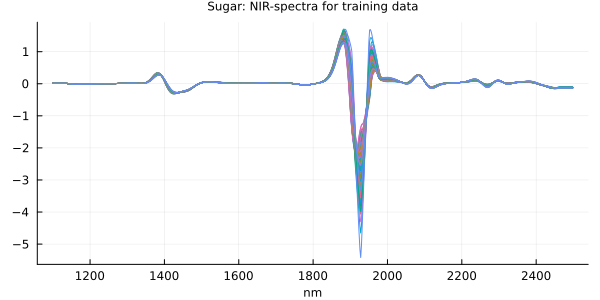

In [188]:
# Load packages and data:
using MAT, VMLS

vars = matread("Sugar.mat")
Xtrain = vars["Xtrain"]; Ytrain = vars["Ytrain"]; 
Xtest = vars["Xtest"];   Ytest = vars["Ytest"];
n1, p = size(Xtrain); 
n2 = size(Xtest,1);

# Plot the columns (samples) of Xtrain:
plot(1100:2:2498, Xtrain', legend = false, size = (600,300), title = "Sugar: NIR-spectra for training data", titlefontsize = 8, labelfontsize = 8, xlabel = "nm") 

In [189]:
size(Xtest)

(21, 700)

In [190]:
# Solve the MOLS-problem and identify a good choice for λ:

npts      = 250; # The number of different λ-values to be used in solving the MOLS-problem.
λ         = 10 .^linspace(-5,5,npts); # The candidate λ-values we will consider

# Choose as 1, 2 or 3 for the response to predict:
response = 1; 

A1 = Xtrain; b1 = Ytrain[:,response]; # For primary objective
A2 = eye(p); b2 = zeros(p);           # For secondary objective
Atest = Xtest;                        # The test-data

err_train = zeros(npts);   # For storing training errors
err_test  = zeros(npts);   # For storing test errors
Θs        = zeros(p,npts); # For storing the MOLS-solutions


@time begin # Measure the time of the modelling process
# Solve the MOLS-problem for each choice of λ-value:
As    = [A1, A2]; 
bs    = [b1, b2];
for k = 1:npts
    λs = [1, λ[k]]; θ = mols_solve(As, bs, λs)
    err_train[k] = rms(Ytrain[:,response] - A1*θ);   # Training error of the MOLS-solution
    err_test[k]  = rms(Ytest[:,response] - Atest*θ); # Test error of the MOLS-solution
    Θs[:,k] = θ;                         # The k-th MOLS solution
end;
end #time

id = argmin(err_test); λ0 = λ[id]; # Identify the λ-value of the model minimizing the test-error.
λ0

  7.714594 seconds (1.06 M allocations: 3.354 GiB, 1.59% gc time)


0.00016025783712413842

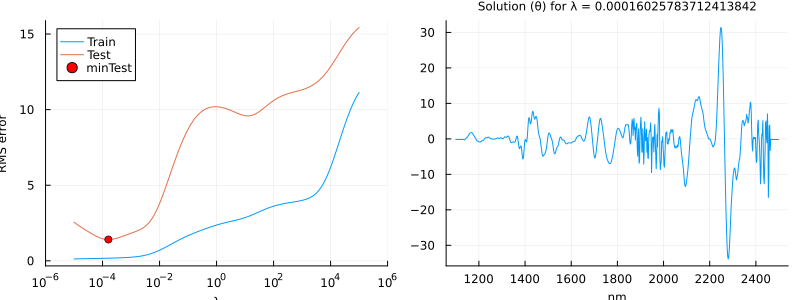

In [191]:
using Plots
# For plotting the RMS errors:
erp = plot(λ, err_train, xscale = :log10, label = "Train", labelfontsize = 8)
plot!(erp, λ, err_test, xscale = :log10, label = "Test")
plot!(erp, xlabel = "λ", ylabel = "RMS error", xlim = (1e-6, 1e6), size=(300,300))
scatter!(erp,[λ0], [err_test[id]], color = "red", label = "minTest", markersize = 4, legend=:topleft)

# For plotting the solution θ corresponding to the choice λ0:
θp = plot(1100:2:2498,Θs[:,id], legend = false, size=(500,300), title = "Solution (θ) for λ = "*string(λ0), xlabel = "nm", titlefontsize = 8, labelfontsize = 8)

plot(erp, θp, layout = (1,2), size=(800,300))   

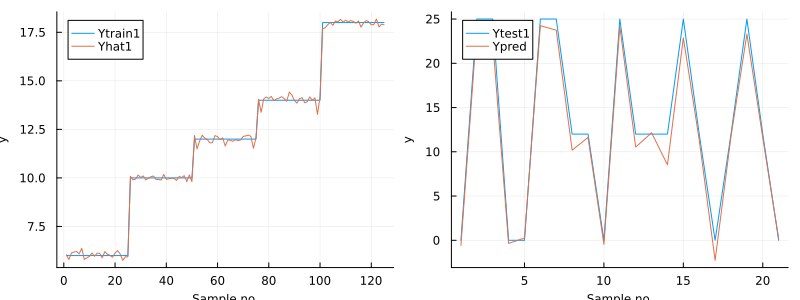

In [192]:
Yhat1 = A1*Θs[:,id];      # The fitted values for the training data
Ypred = Atest*Θs[:,id];   # The predictions for the test data

# Plot of the fitted values and associated true responses:
phat = plot(b1, label = "Ytrain1", xlabel = "Sample no.", ylabel = "y", legend=:topleft, labelfontsize = 8)
plot!(phat, Yhat1, label = "Yhat1")

# Plot of the test-predictions and associated true responses:
ppred = plot(Ytest[:,response], label = "Ytest1", xlabel = "Sample no.", ylabel = "y", legend=:topleft, labelfontsize = 8)
plot!(ppred, Ypred, label = "Ypred")

plot(phat, ppred, layout = (1,2), size=(800,300))  

### Ex. B1 (model selection based on 5-fold cross-validation):
If we want to do real predictions for the $21$ test samples **as independent of the modelling process**, the above use of the test-data to identify a good value for $\lambda$ is **invalid**. 

Instead, we can select $\lambda$ based on $5$-fold cross-validation of the training data for each choice of $\lambda$. Recall what we did in **Julia-notebook exercise 11 (chapter 13)**. 

To do this right, you must calculate and store the predictions for each cross-validation segment to obtain a **rms**-value for each choice of $\lambda$. Then you can identify **the smallest** among the rms-values to obtain a good $\lambda$-value. Finally you shoud make a new model for this choice of $\lambda$ based on all the training data (why?) to do your predictions of the test data.

Write a Julia-program that implements this modelling process, and include the same type of graphics as produced in the above code.

In [193]:
# < write your program here ... > 

### Ex. B2 (speeding up the model building process by using the kernel tric):
You probably noticed that the execution of your progam is quite slow. It is possible to speed up things significantly by replacing the `mols_solve_`-function with an alternative function `wRidge(X,y,λ)` (for "Ridge Regression" with a "wide" matrix) based on the **kernel trick** described in the **Julia-notebook of chapter 15**. Complete the following code to make the function `wRidge(X,y,λ)` work correctly. 

In [194]:
#function wRidge(X,y,λ)You probably noticed that the execution of your progam is quite slow. It is possible to speed up things significantly by replacing the `mols_solve_`-function with an alternative function `wRidge(X,y,λ)` (for "Ridge Regression" with a wide matrix) based on the **kernel trick** described in the **Julia-notebook of chapter 14**. Below, you should 
## Solution based on the kernel trick:
#
# <fill in the required code here>
#
#return θ 
#end

### Ex. B3 (repeat the model selection process from B1):
Revise the model selection and prediction preocess in B1 by using your new function from B2. Measure the **execution time** of the revised modelling process and compare to the corresponding execution time from B1.

In [195]:
# < write your program here ... > 

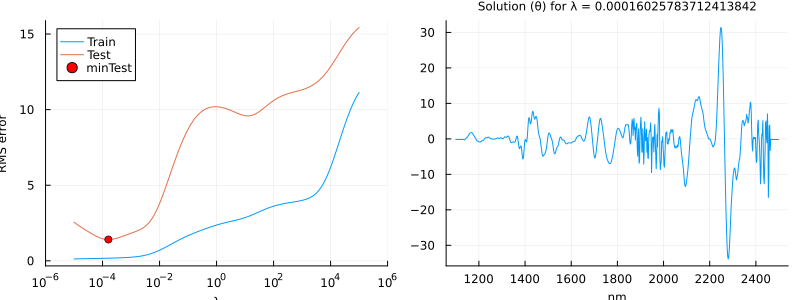

In [196]:
# Keep as above:
using Plots
# For plotting the RMS errors:
erp = plot(λ, err_train, xscale = :log10, label = "Train", labelfontsize = 8)
plot!(erp, λ, err_test, xscale = :log10, label = "Test")
plot!(erp, xlabel = "λ", ylabel = "RMS error", xlim = (1e-6, 1e6), size=(300,300))
scatter!(erp,[λ0], [err_test[id]], color = "red", label = "minTest", markersize = 4, legend=:topleft)

# For plotting the solution θ corresponding to the choice λ0:
θp = plot(1100:2:2498,Θs[:,id], legend = false, size=(500,300), title = "Solution (θ) for λ = "*string(λ0), xlabel = "nm", titlefontsize = 8, labelfontsize = 8)

plot(erp, θp, layout = (1,2), size=(800,300))  

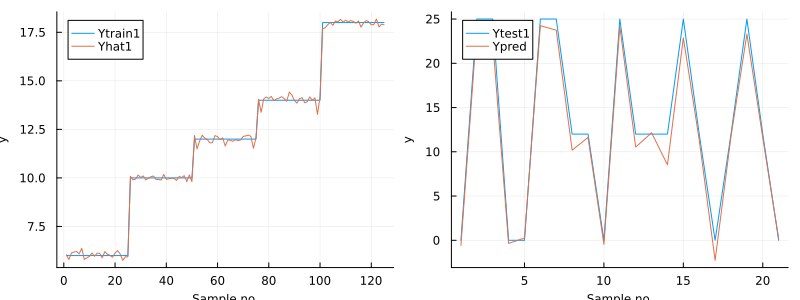

In [197]:
# Keep as above:
Yhat1 = A1*Θs[:,id];      # The fitted values for the training data
Ypred = Atest*Θs[:,id];   # The predictions for the test data

# Plot of the fitted values and associated true responses:
phat = plot(b1, label = "Ytrain1", xlabel = "Sample no.", ylabel = "y", legend=:topleft, labelfontsize = 8)
plot!(phat, Yhat1, label = "Yhat1")

# Plot of the test-predictions and associated true responses:
ppred = plot(Ytest[:,response], label = "Ytest1", xlabel = "Sample no.", ylabel = "y", legend=:topleft, labelfontsize = 8)
plot!(ppred, Ypred, label = "Ypred")

plot(phat, ppred, layout = (1,2), size=(800,300))  

### Ex. B4 (do model selection and predictions for all 3 responses simultaneously):
If correctly implemented,  `Θ=wRidge(Xtrain, Ytrain, λ)` will calculate the solutions for all the $3$ responses in `Ytrain` simultaneously (`Θ` will be a matrix of 3 columns.) Modify your program in B3 to take advantage of this fact (your program should now be able to do the model selections and predictions for all $3$ responses at the roughly the same computational cost as with just $1$ response ...). Note that the  $3$ responses most likely will lead to models using somewhat different choices of `λ`.

In [198]:
# < write your program here ... > 


### Ex. B5 (repeat B1 with a different secondary objective)
Repeat the process from B1 by replacing the secondary objective with $D_p\theta = 0$, where

```julia
Dp = diff(eye(p), dims = 1);
```
is the $(p-1)\times p$ first difference matrix that has the effect of imposing smoothness in the solution vector $\theta$.

Compare the two solutions for $\theta$ by plotting them togehter and share your thoughts. (**NOTE:**  You should not worry about the kernel-trick here - just replace the prescribed objective in your B1-code.)

In [199]:
# < write your program here ... > 


## Part C: More classification  (3 exercises)

### Introduction
We start by summarizing some of our functions for classification modelling, uploading the MNIST-data and repeating the basic least squares classification approaches from chapter 14 (including exercise 14.10).

In [1]:
# Functions that may useful for our classification problems:

# The +/- signs of real number t:
sgn(t) = t>0 ? 1 : -1;  

# The one-hot-encoding function (compact version):
one_hot_(ycl,K) = Int.(hcat([ycl .== i for i = (1:K)]...));

# The row_argmax-function finds the column number of largest value in each row of a matrix (M):
row_argmax(M) = [argmax(M[i,:]) for i = 1:size(M,1)];

# (New) The row_argmaxK-function finds the column numbers of the K largest values in each row of a matrix (M):
row_argmaxK(M,K) = vcat([partialsortperm(vec(M[i,:]), 1:K, rev = true)' for i = 1:size(M,1) ] ...)
argmaxK(v,K) = partialsortperm(vec(v), 1:K, rev = true) # Vector version of row_argmaxK.

# The ls-multiclass function:
function ls_multiclass_(X,Ypm)  # Ypm is the plus/minus one encoding of the class labels
Θ = X\Ypm;                      # The regression coeffs
yhat = row_argmax(X*Θ);         # The predicted class labels
return Θ, yhat
end

# Function for re-coding 0-labels as 10-labels:
code_zero_as_ten(t) = t ≠ 0 ? t : 10 

# Fuction for calculating error-rates from comparing true values and guesses:
error_rate_(ytrue, yguess) = avg(ytrue .!= yguess)

# Function for calculating the confusion matrix of a K-class problem from true values and guesses:
CMAT(ytrue,yguess,K) = hcat([[sum((yguess .== j) .& (ytrue .== i)) for i = 1:K] for j = 1:K ]...)

CMAT (generic function with 1 method)

In [2]:
using MLDatasets

   Resolving package versions...
  No Changes to `~/mla210/Project.toml`
  No Changes to `~/mla210/Manifest.toml`


In [3]:
train_x, train_y = MNIST.traindata()
test_x, test_y = MNIST.testdata()

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/endreasgard/.julia/packages/MLDatasets/mtOdX/src/datasets/vision/mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/endreasgard/.julia/packages/MLDatasets/mtOdX/src/datasets/vision/mnist.jl:195


(features = FixedPointNumbers.N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8;;; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8;;; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8;;; … ;;; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8;;; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8;;; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8], targets = [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [4]:
#---------------------------------
# Load the training and test-data (Note that we re-code 0-labels as 10s):
# train_x, train_y = MNIST.traindata(); train_y = code_zero_as_ten.(train_y) 
# test_x,  test_y  = MNIST.testdata(); test_y = code_zero_as_ten.(test_y);
train_x, train_y = MNIST(split=:train)[:]; train_y = code_zero_as_ten.(train_y) 
test_x,  test_y  = MNIST(split=:test)[:]; test_y = code_zero_as_ten.(test_y);
K = maximum(train_y) # Number of classes

Xtrain = convert(Matrix{Float64}, reshape(permutedims(train_x, (3,1,2)), (60000, 28*28)));
Xtest  = convert(Matrix{Float64}, reshape(permutedims(test_x, (3,1,2)), (10000, 28*28)));

#One-hot and -1/1 encoding:
Ytrain = one_hot_(train_y,K); # Ytest = one_hot_(test_y,K);
Ytrain_pm = 2*Ytrain.-1;      # Ytest_pm  = 2*Ytest .-1;

### Elimination of non-informative pixels
**Pixel position** that contain **the value** $0$ **across almost all images** can clearly be omitted in the classification modelling. We can identify such pixel positions from the training data as follows:

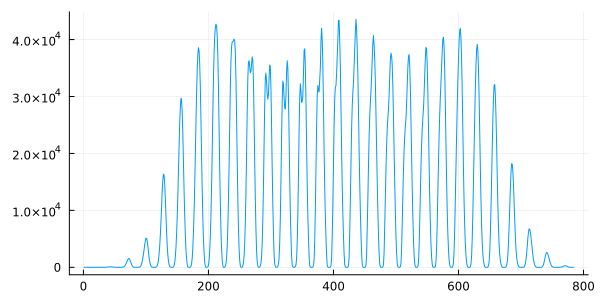

In [5]:
# Visualizing the number of non-zero pixels for each of the 784 pixelpositions in the training dataset:
using Plots
sX = vec(sum(Xtrain.>0, dims = 1));
plot(sX, legend = false, size = (600,300))

### NOTE:
In the following we will **ignore a pixel position** if its values turn out to be **non-zero for less than 600 training images**:

In [6]:
ids = findall(sX.>600); # There are 493 pixel positions where more than 600 images have non-zero values (ref ch. 14 i VMLS)

Xtr = Xtrain[:, ids]; Xte = Xtest[:,ids]; # Our analysis below will be based on these versions of the test- and training data.
# The number of samples and features in training- and test datasets:
n,p  = size(Xtr); nn = size(Xte,1); # Size of training- and test data
K, n,nn,p

(10, 60000, 10000, 493)

### The one-versus-all least squares classifiction:

In [7]:
# Clocking the calculation of regression coefficients and class predictions for the training data:
@time θs, yhat = ls_multiclass_(Xtr,Ytrain_pm); 
Yhat = Xtr*θs; 
Ypred = Xte*θs; 
# yhat = row_argmax(Yhat);
ypred = row_argmax(Ypred);
# Error rates for the test- and training data:
error_rate_(test_y, ypred),  error_rate_(train_y, yhat) 

  1.721379 seconds (2.25 M allocations: 391.448 MiB, 1.68% gc time, 31.09% compilation time)


UndefVarError: UndefVarError: `avg` not defined

In [8]:
# Confusion matrix for test data:
CMTe = CMAT(test_y, ypred, K)

10×10 Matrix{Int64}:
 1107    2    3    1    1    5    2   14    0    0
   57  814   28   16    0   38   19   38    4   18
   15   24  891    2   13   10   23   18   10    4
   22    6    2  868    3    9    1   15   55    1
   16    4   85   18  620   21   13   69   24   22
    9   10    0   19   19  875    0    9    0   17
   39   17    8   19    0    2  880    3   55    5
   55   10   31   25   44   17   13  739   23   17
   10    4   14   73    0    1   79   12  798   18
    0    1    3    1    9   14    1    8    2  941

In [9]:
# Confusion matrix for training data:
CMTr = CMAT(train_y , yhat, K)

10×10 Matrix{Int64}:
 6512    34    17    11    28    16    13   105     5     1
  266  4777   156   105    13   237    90   199    21    94
  147   174  5211    29    89    60   112   137   132    40
  102    54     9  5098    54    56    23    83   353    10
   77    32   528    83  3773   194    45   387   155   147
   71    81     3    58    98  5457     0    47     2   101
  187    42    61   148     8     5  5392    21   347    54
  530    60   221   123   231    63    21  4350   175    77
   63    26   111   357     8     4   514    51  4749    66
   11    20    19    25    43    76     3    64     6  5656

As can be seen, **the resulting classifier is about 15% wrong** on both the training- and test data.

## Ex. C1:


**Below we will pursue an idea of feature extraxcion by considering the `Yhat` & `Ypred` values obtained by a least squares model for predicting the -1/1 encoding:**

Before applying the `row_argmax` to  `Yhat` and `Ypred` to obtain the predicted classification labels for the above one versus all classifier results we can consider them as additional features for building another classification model.

Fill in explanations that 

* 1) makes the following two feature extraction functions understandable.
* 2) describes the features and classification results of the repeated one-versus-all least squares classifiction.

In [10]:
# Ex. C1 - part 1:
# ----------------
vals2votes(Yhat) = vcat([ ((Yhat[i,:] .- minimum(Yhat[i,:])) ./ (maximum(Yhat[i,:]) - minimum(Yhat[i,:])) )' for i = 1:size(Yhat,1)] ...)
# <FILL IN an explanation of how to understand this function> 

# 1. iterate over each row in y_hat (1*10 row vector) 
# 2. Calculate min and max values in the row
# 3. Subtract min and divide by (max - min) (normalize all values between 0 and 1 with min = 0 and max = 1)
# 4. transpose and concat 

# Rows represent a sample, and a score between 0 and 1 for each class 



function ranks2votes(Yhat,K) 
# <FILL IN an explanation of how to understand this function>     
    M = row_argmaxK(Yhat,K);
    v = K:-1:1;
    for i = 1:size(M,1);
        M[i,M[i,:]] = v;
    end
    return M ./K
end

#Finds the top K votes for each sample,
#and assigns the votes 1,2,...,K to vector M
#(where K is the number of classes)
#Then normalizes the votes to be between 0 and 1


ranks2votes (generic function with 1 method)

In [19]:
# Ex. C1 - part 2:
# ----------------
YhatV  = vals2votes(Yhat); YpredV = vals2votes(Ypred);
YhatR  = ranks2votes(Yhat,K); YpredR = ranks2votes(Ypred,K);
X1 = [Xtr Yhat max.(Yhat,0) YhatR YhatV]; # 
X2 = [Xte Ypred max.(Ypred,0) YpredR YpredV]; # 

# <FILL IN an explanation of what goes on here... >

# 1. Concatenate the training data with the predictions from the training data
# 2. Concatenate the test data with the predictions from the test data #both vals2votes and ranks2votes
#So we have the original data, the positive predictions, the ranked predictions, and the normalized predictions for both the training and test data
#and we are checking if it gives improved accuracy or not

#Looks like it is faster, and it improves the accuracy


@time θs, yhat = ls_multiclass_(X1,Ytrain_pm); 
Yhat = X1*θs; Ypred = X2*θs; 
ypred = row_argmax(Ypred); # yhat = row_argmax(Yhat);

# Error rates for the test- and training data:
error_rate_(test_y, ypred),  error_rate_(train_y, yhat)    

  1.481101 seconds (63.30 k allocations: 264.602 MiB, 2.41% gc time, 0.21% compilation time)


(0.1028, 0.09945)

## Ex. C2:
Use the **new above ideas on feature extraction** in combination with the ideas on **random features** from the **Classification - MNIST** notebook. 

Design new least squares classifiers (as good as possible) for both the **MNIST-dataset**.

**NOTE:** Don't use more than $1000$ new random features in your classifiers & make sure that the test data has no influence on your choices of classifier.

### Recall the faster implementation of the voting based one-versus-one multi-class classifier:

**Note that** the normal equations for the class $i$ versus the class $j$ problem are

$$(A_i^TA_i + A_j^TA_j)\theta_{ij} = (A_i^T1-A_j^T1),$$

where $A_i$ and $A_j$ are the rows of $X_{train}$-matrix associated with the samples of class $i$ and $j$ respectively. Because the matrix products $A_k^TA_k$ and $A_k^T1$ for $k=1,...,K$ are repeated many times according to the various combinations of classes in the one-to-one problems, we can benefit from pre-computing and storing them for repeated use. 

We use the notation $G_k=A_k^TA_k$ (recall that the $G_k$s are [**Gram matrices**](https://web.stanford.edu/~boyd/vmls/vmls.pdf#page=191), see [more here](https://en.wikipedia.org/wiki/Gram_matrix)) and $h_k = A_k^T1$ (note that the $h_k$s are just the transpose of the column sums of $A_k$) below.

In this notation the normal equations for the  class $i$ versus the class $j$ problem are

$$(G_i + G_j)\theta_{ij} = (h_i-h_j).$$

### MY CODE

In [31]:
println(size(X1))
println(size(X2))

(60000, 533)
(10000, 533)


In [32]:
ReLu(x) = max(x,0);

In [33]:
nrf = 1000;     # 1500 new features
R   = rand([-1,1],p,nrf); # The random feature generation matric #R   = sign.(rand(p,nrf).-0.5);

# The training- and test data matrices augmented with the ReLu-transformed random features.
XtrainE = [X1 ReLu.(X1*R)]; 
XtestE  = [X2 ReLu.(X2*R)]; 

In [34]:
println(size(XtrainE))
println(size(XtestE))

(60000, 1533)
(10000, 1533)


In [41]:
p = 1533; # num tot features
#k,n,nn,p(10, 60000, 10000, 493)

1533

In [55]:
θ = XtrainE\Ytrain_pm;
Yhat = XtrainE*θ;
Ypred = XtestE*θ;


ypred = row_argmax(Ypred); # yhat = row_argmax(Yhat);
yhat = row_argmax(Yhat);

# Error rates for the test- and training data:
error_rate_(test_y, ypred),  error_rate_(train_y, yhat)


(0.0564, 0.049833333333333334)

In [38]:
# Precomputing the Gi's and the hi's: 
G = Array{Float64, 3}(undef,K,p,p);
h = Array{Float64, 2}(undef,K,p);


for i = 1:K
    ids = findall(train_y .== i);   
    #ni = length(idsi); oni = ones(ni)
    Ai = XtrainE[ids,:]
    G[i,:,:] = Ai'*Ai;
    h[i,:] = sum(Ai',dims=2) #  Ai'*oni; #
end

In [43]:
# Calculate the coefficients for all the one-versus-one classification models:
Θ = 0*Array{Float64, 3}(undef,K,K,p);

@time begin   
for i = 1:K-1
    for j = i+1:K 
       Θ[i,j,:] = pinv(G[i,:,:]+G[j,:,:])*vec(h[i,:]-h[j,:]);
       #Θ[i,j,:] = (G[i,:,:]+G[j,:,:])\vec(h[i,:]-h[j,:]);
       Θ[j,i,:] = -Θ[i,j,:];    
    end
end
   
# Classify the samples and collect the votes:
Votes_train = zeros(n,K);  # Voting matrix for the training data. 
Votes_test  = zeros(nn,K);  # Voting matrix for the test data.

# For all pairs (i,j) of groups
for i = 1:K-1 
    for j = i+1:K

    # Classify the entire training dataset to assign the "ij"-votes for all samples:
    Yhat  = XtrainE*Θ[i,j,:]; 
    ci_train = findall(Yhat .> 0); # Indices of training-samples classified as group "i".
    Votes_train[ci_train,i] .+= 1; # = Votes_train[ci_train,i] .+ 1; # Update votes
    cj_train = findall(Yhat .< 0); # Indices of training-samples classified as group "j".
    Votes_train[cj_train,j] .+= 1; # = Votes_train[cj_train,j] .+ 1; # Update votes

    # Classify the entire test dataset to assign the "ij"-votes for all samples:    
    Ypred = XtestE*Θ[i,j,:];
    ci_test = findall(Ypred .> 0); # Indices of test-samples classified as group "i".
    Votes_test[ci_test,i]   .+= 1; # = Votes_test[ci_test,i] .+ 1; # Update votes  
    cj_test = findall(Ypred .< 0); # Indices of test-samples classified as group "j".
    Votes_test[cj_test,j]   .+= 1; # = Votes_test[cj_test,j] .+ 1; # Update votes 
        
    end
end
    
end # time

 33.620944 seconds (354.56 k allocations: 8.781 GiB, 10.29% gc time, 0.75% compilation time)


In [45]:
Yhat  = row_argmax(Votes_train); pcc_train = sum(Yhat.==train_y)/n;
Ypred = row_argmax(Votes_test);  pcc_test = sum(Ypred.==test_y)/nn;

# The %  error rate for training- and testdata.
error_rate_(train_y,Yhat), error_rate_(test_y,Ypred)

(0.017483333333333333, 0.034)

>We got a better accuracy and a really powerful model. Although it comes at a cost, taking 10 times longer to run

>#### MOD: 33.620944 seconds (354.56 k allocations: 8.781 GiB, 10.29% gc time, 0.75% compilation time)

>#### UNMOD: 3.264119 seconds (4.36 k allocations: 1001.794 MiB, 1.02% gc time)


### CODE UNMODIFIED

In [46]:
p = 493; # Number of features org

In [47]:
# Precomputing the Gi's and the hi's: 
G = Array{Float64, 3}(undef,K,p,p);
h = Array{Float64, 2}(undef,K,p);


for i = 1:K
    ids = findall(train_y .== i);   
    #ni = length(idsi); oni = ones(ni)
    Ai = Xtr[ids,:]
    G[i,:,:] = Ai'*Ai;
    h[i,:] = sum(Ai',dims=2) #  Ai'*oni; #
end

In [48]:
# Calculate the coefficients for all the one-versus-one classification models:
Θ = 0*Array{Float64, 3}(undef,K,K,p);

@time begin   
for i = 1:K-1
    for j = i+1:K 
       Θ[i,j,:] = pinv(G[i,:,:]+G[j,:,:])*vec(h[i,:]-h[j,:]);
       #Θ[i,j,:] = (G[i,:,:]+G[j,:,:])\vec(h[i,:]-h[j,:]);
       Θ[j,i,:] = -Θ[i,j,:];    
    end
end
   
# Classify the samples and collect the votes:
Votes_train = zeros(n,K);  # Voting matrix for the training data. 
Votes_test  = zeros(nn,K);  # Voting matrix for the test data.

# For all pairs (i,j) of groups
for i = 1:K-1 
    for j = i+1:K

    # Classify the entire training dataset to assign the "ij"-votes for all samples:
    Yhat  = Xtr*Θ[i,j,:]; 
    ci_train = findall(Yhat .> 0); # Indices of training-samples classified as group "i".
    Votes_train[ci_train,i] .+= 1; # = Votes_train[ci_train,i] .+ 1; # Update votes
    cj_train = findall(Yhat .< 0); # Indices of training-samples classified as group "j".
    Votes_train[cj_train,j] .+= 1; # = Votes_train[cj_train,j] .+ 1; # Update votes

    # Classify the entire test dataset to assign the "ij"-votes for all samples:    
    Ypred = Xte*Θ[i,j,:];
    ci_test = findall(Ypred .> 0); # Indices of test-samples classified as group "i".
    Votes_test[ci_test,i]   .+= 1; # = Votes_test[ci_test,i] .+ 1; # Update votes  
    cj_test = findall(Ypred .< 0); # Indices of test-samples classified as group "j".
    Votes_test[cj_test,j]   .+= 1; # = Votes_test[cj_test,j] .+ 1; # Update votes 
        
    end
end
    
end # time

  3.264119 seconds (4.36 k allocations: 1001.794 MiB, 1.02% gc time)


In [49]:
Yhat  = row_argmax(Votes_train); pcc_train = sum(Yhat.==train_y)/n;
Ypred = row_argmax(Votes_test);  pcc_test = sum(Ypred.==test_y)/nn;

# The %  error rate for training- and testdata.
error_rate_(train_y,Yhat), error_rate_(test_y,Ypred)

(0.0651, 0.0711)

In [51]:
## Simple least squares multiclass classification

# Solve X'Xθ = X'Y for θ
X = XtrainE
X_test = XtestE

Y = train_y 

Θ = X\Y
Yhat = X*Θ

ypred = X_test*Θ

error_rate_(test_y, ypred), error_rate_(train_y, Yhat)


(1.0, 1.0)

## Ex. C3:
Repeat Ex. C2 by also taking the above ideas of one-to-one classification into consideration.